<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Alzheimer's Image Classification

---
## Problem Statement

Fill this in

---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.6.0
Found GPU at: /device:GPU:0


In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall

## Baseline Neural Network

### Train and Test Data

In [23]:
# Create Test and Train 
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.33)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_dir = '/content/drive/MyDrive/data/train'
test_dir = '/content/drive/MyDrive/data/test'

img_width = 176
img_height = 208

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

validation_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical'
)

Found 3433 images belonging to 4 classes.
Found 1688 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [16]:
train_steps = train_gen.samples // train_gen.batch_size
val_steps = validation_gen.samples // validation_gen.batch_size
print(train_steps)
print(val_steps)

53
26


In [17]:
train_gen.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [18]:
train_gen.image_shape

(150, 150, 3)

In [19]:
pd.Series(test_gen.classes).value_counts(normalize=True)

2    0.500391
3    0.350274
0    0.139953
1    0.009382
dtype: float64

Base line accuracy is 50%

### Basic Convolutional Neural Network

In [24]:
# Neural Net architecture referenced from "Deep Learning with Python by Francois Chollet: Chapter 5"

def create_model():
  model = Sequential()
  model.add(Conv2D(
      filters=32,
      kernel_size=(3, 3),
      activation='relu',
      input_shape=(img_height, img_width, 3)
  ))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(
      filters=64,
      kernel_size=(3, 3),
      activation='relu' 
  ))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(
      filters=128,
      kernel_size=(3, 3),
      activation='relu'
  ))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall()])
  return model

In [28]:
model = create_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 206, 174, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 103, 87, 32)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 101, 85, 64)       18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 42, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 40, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 24, 20, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 61440)            

In [29]:
with tf.device('/device:GPU:0'):
  history = model.fit(
      train_gen,
      validation_data=validation_gen,
      epochs=60,
      steps_per_epoch=train_steps,
      validation_steps=val_steps
  )

Epoch 1/60
53/53 [==============================] - 10s 183ms/step - loss: 1.0995 - accuracy: 0.5358 - precision_4: 0.5619 - recall_4: 0.3514 - val_loss: 1.3689 - val_accuracy: 0.3143 - val_precision_4: 0.3695 - val_recall_4: 0.2230
Epoch 2/60
53/53 [==============================] - 9s 178ms/step - loss: 0.7752 - accuracy: 0.6640 - precision_4: 0.7075 - recall_4: 0.5886 - val_loss: 1.7382 - val_accuracy: 0.2650 - val_precision_4: 0.2669 - val_recall_4: 0.2236
Epoch 3/60
53/53 [==============================] - 9s 175ms/step - loss: 0.5685 - accuracy: 0.7608 - precision_4: 0.7978 - recall_4: 0.7228 - val_loss: 1.8942 - val_accuracy: 0.3666 - val_precision_4: 0.3671 - val_recall_4: 0.3287
Epoch 4/60
53/53 [==============================] - 9s 177ms/step - loss: 0.3684 - accuracy: 0.8537 - precision_4: 0.8730 - recall_4: 0.8347 - val_loss: 1.9749 - val_accuracy: 0.3516 - val_precision_4: 0.3577 - val_recall_4: 0.3269
Epoch 5/60
53/53 [==============================] - 9s 176ms/step - los

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

prec = history.history['precision_4']
val_prec = history.history['val_precision_4']

recall = history.history['recall_4']
val_recall = history.history['val_recall_4']

epochs_range = range(60)

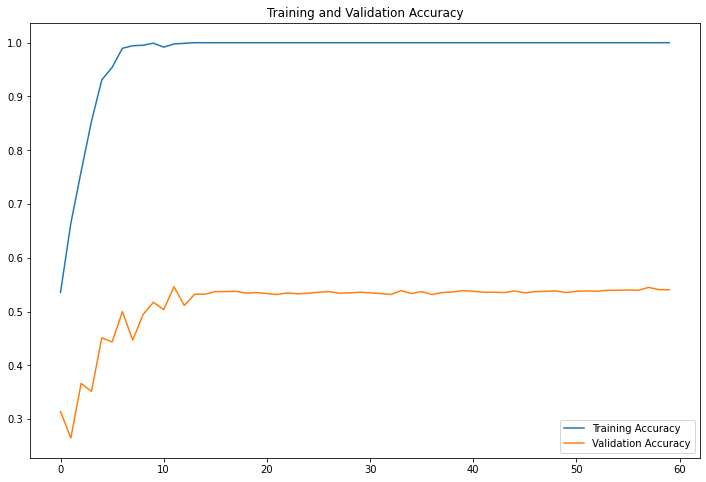

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

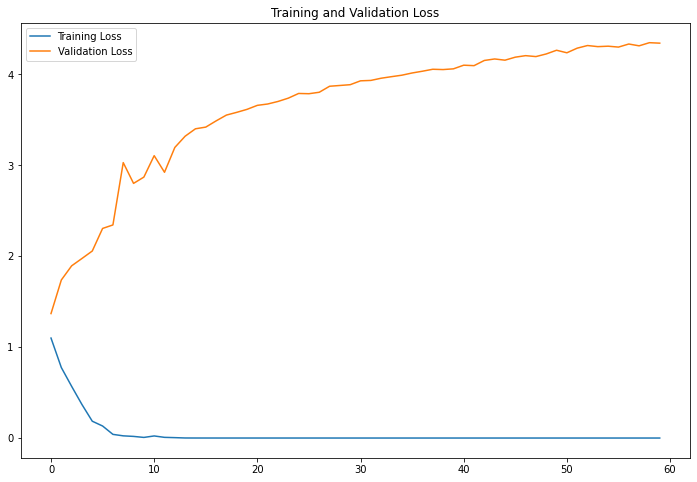

In [33]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

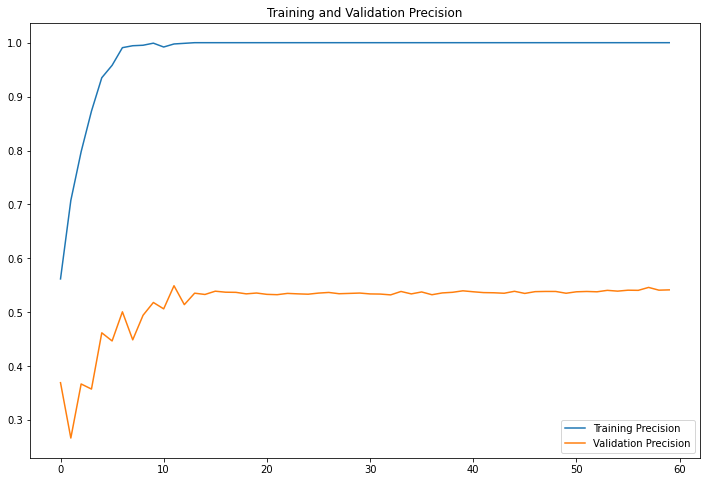

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, prec, label='Training Precision')
plt.plot(epochs_range, val_prec, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.legend()

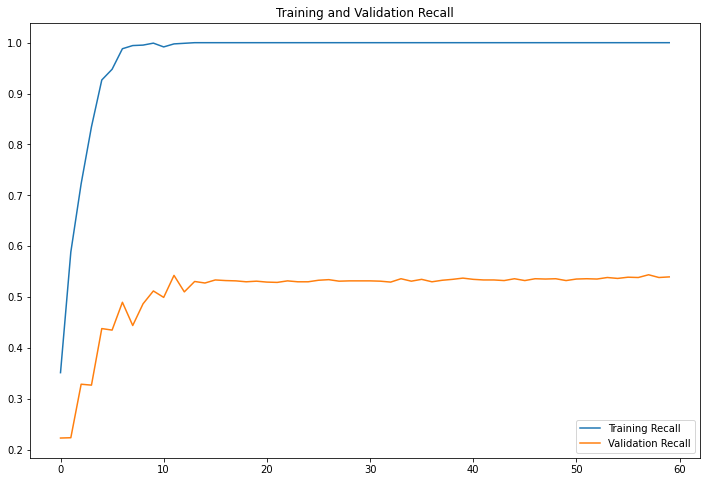

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.legend()

Based on all the charts, this initial model is severly overfit. After about 14 epochs the model stops improving. Model is slightly better than the base model with the best Accuracy score at about 55%, the best Precision was about 55% and Recall was about 54%.